# Household Income

## Data Pre-Processing

In [26]:
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
import pickle
geolocator = Nominatim(user_agent="http")
from shapely import wkt
import geopandas as gpd
from shapely.geometry import Point
from ipywidgets import FloatProgress
from IPython.display import display
import time
from unidecode import unidecode
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

In [2]:
# Load the US counties shapefile
counties = gpd.read_file("./../Data/Median_Income/us-county-boundaries/us-county-boundaries.shp")

In [3]:
counties.crs = 'epsg:4326'

In [4]:
coordinate = (-73.94215905541955, 40.821116833242954)
point_gdf = gpd.GeoDataFrame(geometry=[Point(coordinate)], crs=counties.crs)
# Check which county contains the point
result = gpd.sjoin(point_gdf, counties, how="inner", predicate='within')
print (str(result['namelsad'][0]) + ' ' + str(result['stusab'][0]))

New York County NY


In [5]:
# return county given latitude and longitude
def extract_county(latitude, longitude):
    coordinate = (longitude, latitude)
    point_gdf = gpd.GeoDataFrame(geometry=[Point(coordinate)], crs=counties.crs)
    # Check which county contains the point
    result = gpd.sjoin(point_gdf, counties, how="inner", predicate='within')
    if len(result) == 0:
        return 0
    return str(result['namelsad'][0]) + ' ' + str(result['stusab'][0])

In [6]:
# load coordinate data
coord_file = open('./local_storage/coords.pkl', 'rb')
[latitudes, longitudes] = pickle.load(coord_file)

print(latitudes[0], latitudes[-1])
print(longitudes[0], longitudes[-1])

23.60416666666667 50.22916666666667
-125.1875 -66.5625


In [7]:
# load median household income data
filepath = './../Data/Median_Income/median_incomes.csv'
years = np.arange(2010, 2022, 1)
num_counties = []
median_income_df = pd.read_csv(filepath)
print(median_income_df.head)

<bound method NDFrame.head of         metro_nonmetro  year                   county_name state_abbr  \
0         Metropolitan  2010        Anchorage Municipality         AK   
1         Metropolitan  2010  Fairbanks North Star Borough         AK   
2         Metropolitan  2010     Matanuska-Susitna Borough         AK   
3         Metropolitan  2010                Autauga County         AL   
4         Metropolitan  2010                Baldwin County         AL   
...                ...   ...                           ...        ...   
37689  Nonmetropolitan  2021             Sweetwater County         WY   
37690  Nonmetropolitan  2021                  Teton County         WY   
37691  Nonmetropolitan  2021                  Uinta County         WY   
37692  Nonmetropolitan  2021               Washakie County         WY   
37693  Nonmetropolitan  2021                 Weston County         WY   

           geoId   value  
0      us-ak-020   70524  
1      us-ak-090   60472  
2      us-ak

In [8]:
# extract county names and find the county added in 2020
county_names_yearly = []
for year in years:
    df_year = median_income_df[median_income_df['year'] == year]
    county_name_year = [str(df_year['county_name'][x]) + " " + str(df_year['state_abbr'][x]) for x in df_year.index]
    county_names_yearly.append(county_name_year)
    print(year, len(df_year))
county_names = set.intersection(*map(set,county_names_yearly))
# added county
print(set(county_names_yearly[0]).symmetric_difference(set(county_names_yearly[-1])))
excluded_name = str(set(county_names_yearly[0]).symmetric_difference(set(county_names_yearly[-1])))[2:-5]
print(excluded_name)

2010 3141
2011 3141
2012 3141
2013 3141
2014 3141
2015 3141
2016 3141
2017 3141
2018 3141
2019 3141
2020 3142
2021 3142
{'Copper River Census Area AK'}
Copper River Census Area


In [9]:
# # Create county grid

# county_grid = []

# max_count = len(latitudes) * len(longitudes)
# max_count_scaled = max_count / 100.
# count_reciprocal = 1. / max_count_scaled
# f = FloatProgress(min=0., max=100.1)
# display(f)

# for i in range(len(latitudes)):
#     lat_i_counties = []
#     for j in range(len(longitudes)):
#         county = extract_county(latitudes[i], longitudes[j])
#         lat_i_counties.append(county)
#         f.value += count_reciprocal
#     county_grid.append(lat_i_counties)
# county_grid = np.array(county_grid)

# file_counties = open('./../Data/LargeFileStorage/counties.pkl', 'wb')
# pickle.dump(county_grid, file_counties)
# file_counties.close()
# print(np.unique(county_grid))
# print(len(np.unique(county_grid)))

In [10]:
# Load and test county grid

file_counties = open('./../Data/LargeFileStorage/counties.pkl', 'rb')
county_grid = pickle.load(file_counties)
grid_counties = np.unique(county_grid)
print(grid_counties)
print(len(grid_counties))

['0' 'Abbeville County SC' 'Acadia Parish LA' ... 'Zapata County TX'
 'Zavala County TX' 'Ziebach County SD']
3108


In [11]:
county_grid_normalized = []
for row in county_grid:
    county_row = []
    for cell in row:
        county_row.append(unidecode(cell.upper()))
    county_grid_normalized.append(county_row)

print(county_grid_normalized[200][600])

RUNNELS COUNTY TX


In [12]:
data_series = dict()
years = np.arange(2010, 2022, 1)
county_names_split = set()
count = 0
for ind in median_income_df.index:
    if median_income_df['county_name'][ind] != excluded_name:
        county_names_split.add(unidecode(str(median_income_df['county_name'][ind]) + " " + str(median_income_df['state_abbr'][ind])))
        # print first 10 counties to test
        if count <= 10:
            print(unidecode(str(median_income_df['county_name'][ind]) + " " + str(median_income_df['state_abbr'][ind])))
            count += 1

for county_name in county_names_split:
    name_first = county_name[:-3]
    name_last = county_name[-2:]
    county_df = median_income_df[(median_income_df['county_name'] == name_first) & (median_income_df['state_abbr'] == name_last)]
    year_data = []
    for year in years:
        year_data.append(int(county_df[county_df['year'] == year]['value']))
    data_series[county_name.upper()] = year_data


Anchorage Municipality AK
Fairbanks North Star Borough AK
Matanuska-Susitna Borough AK
Autauga County AL
Baldwin County AL
Bibb County AL
Blount County AL
Calhoun County AL
Chilton County AL
Colbert County AL
Elmore County AL


C:\Users\Astro\AppData\Local\Temp\ipykernel_31868\408756450.py:19: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  year_data.append(int(county_df[county_df['year'] == year]['value']))


In [13]:
print(data_series['KING COUNTY WA'])
data_series[0] = [0] * 12
print(data_series[0])
data_series_list = np.array(list(data_series.values()))
print(data_series_list.shape)
print(max(data_series_list.flatten()))

[66147, 68596, 68944, 71779, 75738, 81816, 85907, 89519, 94822, 102338, 102620, 110351]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
(3142, 12)
160305


In [14]:
def median_income_grid(year, grid, reference):
    new_grid = []
    for x in grid:
        new_row = []
        for y in x:
            if y == '0':
                new_row.append(0)
                continue
            new_row.append(reference[y][year - 2010])
        new_grid.append(new_row)
    return new_grid

In [15]:
sns.set(rc={'figure.figsize':(8,4)})
file_names = []
for year in years:
    ax = sns.heatmap(np.flipud((np.array(median_income_grid(year, county_grid_normalized, data_series)))), vmin=0, vmax = 175000, square=True)
    ax.set_title(year)
    ax.set(xticklabels=[], yticklabels=[])
    ax.tick_params(bottom=False, left=False)
    fig = ax.get_figure()
    file_name = "./figures/household_income/" + str(year) + "_household_income.png"
    fig.savefig(file_name)
    file_names.append(file_name)
    fig.clear()
    ax.clear()

<Figure size 800x400 with 0 Axes>

In [16]:
from PIL import Image

# Gather all PNG files in the current directory
images = [Image.open(file) for file in file_names]

# Set the duration for each frame in milliseconds
duration = 100

# Save the images as a GIF animation
images[0].save('./figures/median_household_income.gif', save_all=True, append_images=images[1:], optimize=False, duration=duration, loop=0)

## Building the Model

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split

In [18]:
# setting this for reproducibility
tf.random.set_seed(42)

In [19]:
def build_dataset(data_array, prop):
    X = []
    Y = []
    mean = np.mean(data_array)
    std = np.std(data_array)
    for row in data_array:
        X.append((row[:10] - mean) / std)
        X.append((row[1:11] - mean) / std)
        Y.append((row[-2] - mean) / std)
        Y.append((row[-1] - mean) / std)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=prop)
    return np.array(X_train), np.array(X_test), np.array(Y_train), np.array(Y_test), mean, std

In [20]:
X_train, X_test, Y_train, Y_test, mean, std = build_dataset(data_series_list, 0.20)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

(5027, 10) (1257, 10) (5027,) (1257,)


In [21]:
def normalize(data, std, mean):
    return (data - mean) / std

def unnormalize(data, std, mean):
    return data * std + mean

In [22]:
# hyperparameters
n_neuron        = 16
activation      = 'relu'
num_epochs      = 50
learning_rate   = 1e-4
minibatch_size  = 64

In [30]:
neuron_arr          = [8, 16, 32]
activation_arr      = ['relu', 'sigmoid', 'softmax', 'tanh']  # activation function
learning_rate_arr   = [1e-3, 1e-4, 1e-5, 1e-6] # learning rate
minibatch_size_arr  = [32, 64, 256]   # batch size
param_arr           = [neuron_arr, activation_arr, learning_rate_arr, minibatch_size_arr]
param_list = list(itertools.product(*param_arr))
print(len(param_list))

144


In [31]:
def build_test_model(params, X_train, y_train):
    n_neuron = params['n_neuron']
    activation = params['activation']
    learning_rate = params['learning_rate']
    minibatch_size = params['minibatch_size']

    lstm_model = Sequential()
    lstm_model.add(LSTM(n_neuron,input_shape=(10, 1),
                return_sequences=True,activation=activation))
    lstm_model.add(LSTM(8,return_sequences=False,
                activation=activation))
    lstm_model.add(Dense(2,activation=activation))
    lstm_model.add(Dense(1,activation='linear')) 

    lstm_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

    # lstm_model.summary()

    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

    history = lstm_model.fit(X_train, y_train, 
                            batch_size = minibatch_size,
                            epochs = 50,
                            validation_split=0.2, verbose=0,
                            callbacks=[early_stop],
                            shuffle=False)
    return lstm_model, history


In [37]:
loss_list = []
i = 0
for param_set in param_list:
    print("PARAM SET " + str(i + 1) + "/" + str(len(param_list)) + " " + str(param_set))
    params = {}
    params['n_neuron'] = param_set[0]
    params['activation'] = param_set[1]
    params['learning_rate'] = param_set[2]
    params['minibatch_size'] = param_set[3]
    curr_model, curr_history = build_test_model(params, X_train, Y_train)
    loss_list.append(curr_history.history['val_loss'][-1])
    print("\tTraining Loss:  \t" + str(curr_history.history['loss'][-1]))
    print("\tValidation Loss:\t" + str(curr_history.history['val_loss'][-1]))
    i += 1

PARAM SET 1/144 (8, 'relu', 0.001, 32)
	Training Loss:  	0.1088109016418457
	Validation Loss:	0.10466252267360687
PARAM SET 2/144 (8, 'relu', 0.001, 64)
	Training Loss:  	0.22435355186462402
	Validation Loss:	0.24134357273578644
PARAM SET 3/144 (8, 'relu', 0.001, 256)
	Training Loss:  	0.6841858625411987
	Validation Loss:	0.7293012738227844
PARAM SET 4/144 (8, 'relu', 0.0001, 32)
	Training Loss:  	0.07605892419815063
	Validation Loss:	0.06945556402206421
PARAM SET 5/144 (8, 'relu', 0.0001, 64)
	Training Loss:  	1.0077897310256958
	Validation Loss:	1.070468783378601
PARAM SET 6/144 (8, 'relu', 0.0001, 256)
	Training Loss:  	0.24356846511363983
	Validation Loss:	0.24070081114768982
PARAM SET 7/144 (8, 'relu', 1e-05, 32)
	Training Loss:  	1.2992111444473267
	Validation Loss:	1.3751096725463867
PARAM SET 8/144 (8, 'relu', 1e-05, 64)
	Training Loss:  	1.3610039949417114
	Validation Loss:	1.4415082931518555
PARAM SET 9/144 (8, 'relu', 1e-05, 256)
	Training Loss:  	1.3559151887893677
	Validat

In [40]:
print(loss_list.index(min(loss_list)))
# PARAM SET 97/144 (32, 'relu', 0.001, 32)

96


In [41]:
neuron_arr          = [32]
activation_arr      = ['relu']  # activation function
learning_rate_arr   = [1e-2, 5e-3, 2e-3, 1e-3] # learning rate
minibatch_size_arr  = [4, 8, 16, 32]   # batch size
param_arr           = [neuron_arr, activation_arr, learning_rate_arr, minibatch_size_arr]
param_list = list(itertools.product(*param_arr))
print(len(param_list))

loss_list = []
i = 0
for param_set in param_list:
    print("PARAM SET " + str(i + 1) + "/" + str(len(param_list)) + " " + str(param_set))
    params = {}
    params['n_neuron'] = param_set[0]
    params['activation'] = param_set[1]
    params['learning_rate'] = param_set[2]
    params['minibatch_size'] = param_set[3]
    curr_model, curr_history = build_test_model(params, X_train, Y_train)
    loss_list.append(curr_history.history['val_loss'][-1])
    print("\tTraining Loss:  \t" + str(curr_history.history['loss'][-1]))
    print("\tValidation Loss:\t" + str(curr_history.history['val_loss'][-1]))
    i += 1

16
PARAM SET 1/16 (32, 'relu', 0.01, 4)
	Training Loss:  	0.08847998827695847
	Validation Loss:	0.09563431888818741
PARAM SET 2/16 (32, 'relu', 0.01, 8)
	Training Loss:  	0.07623329758644104
	Validation Loss:	0.06573156267404556
PARAM SET 3/16 (32, 'relu', 0.01, 16)
	Training Loss:  	0.0743025541305542
	Validation Loss:	0.06048974767327309
PARAM SET 4/16 (32, 'relu', 0.01, 32)
	Training Loss:  	1.1177226305007935
	Validation Loss:	1.1693133115768433
PARAM SET 5/16 (32, 'relu', 0.005, 4)
	Training Loss:  	0.07491179555654526
	Validation Loss:	0.06460486352443695
PARAM SET 6/16 (32, 'relu', 0.005, 8)
	Training Loss:  	0.07184012979269028
	Validation Loss:	0.06005636230111122
PARAM SET 7/16 (32, 'relu', 0.005, 16)
	Training Loss:  	0.07399001717567444
	Validation Loss:	0.061033643782138824
PARAM SET 8/16 (32, 'relu', 0.005, 32)
	Training Loss:  	0.07121019810438156
	Validation Loss:	0.060304250568151474
PARAM SET 9/16 (32, 'relu', 0.002, 4)
	Training Loss:  	0.06830667704343796
	Validatio

In [45]:
# FINAL PARAMS: PARAM SET 13/16 (32, 'relu', 0.001, 4)
final_params = {}
final_params['n_neuron'] = 32
final_params['activation'] = 'relu'
final_params['learning_rate'] = 0.001
final_params['minibatch_size'] = 4
X = []
Y = []
mean = np.mean(data_series_list)
std = np.std(data_series_list)
for row in data_series_list:
    X.append((row[:10] - mean) / std)
    X.append((row[1:11] - mean) / std)
    Y.append((row[-2] - mean) / std)
    Y.append((row[-1] - mean) / std)
    
X = np.array(X)
Y = np.array(Y)

final_model, final_history = build_test_model(params, X, Y)
print(final_history.history['loss'][-1])
print(final_history.history['val_loss'][-1])

0.0665641576051712
0.07333212345838547


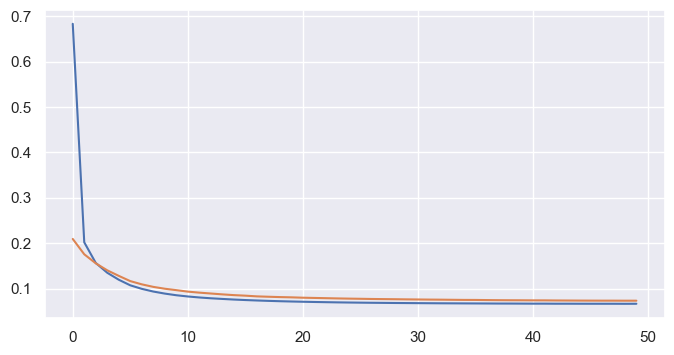

In [48]:
loss_x = np.arange(0, len(final_history.history['loss']), 1)
final_model.save('./final_models/LSTM_household_model.keras')
plt.plot(loss_x, final_history.history['loss'])
plt.plot(loss_x, final_history.history['val_loss'])

In [50]:
year_projections = np.arange(2010, 2035, 1)
data_series_normalized_extended = dict()
count = 0
n_keys = len(data_series.keys())
for key in data_series:
    print(str(count) + "/" + str(n_keys) + ": " + str(key))
    county_data = list(np.copy(normalize(data_series[key], std, mean)))
    # print(type(county_data[0]))
    for i in range(2035 - 2021):
        prediction = final_model.predict((county_data[-10:],), verbose=False)
        county_data.append(np.float64(prediction[0][0]))
        # print(i, type(prediction[0][0]), county_data)
    data_series_normalized_extended[key] = county_data
    count += 1
    
# save projections
file_median_projections = open('./local_storage/median_income_projections.pkl', 'wb')
pickle.dump(data_series_normalized_extended, file_median_projections)
file_median_projections.close()

0/3142: LAKE COUNTY FL
1/3142: PLYMOUTH COUNTY MA
2/3142: JOHNSON COUNTY IN
3/3142: WORTH COUNTY MO
4/3142: TRANSYLVANIA COUNTY NC
5/3142: HAAKON COUNTY SD
6/3142: GRANT COUNTY KS
7/3142: DEL NORTE COUNTY CA
8/3142: RUSH COUNTY IN
9/3142: PICKAWAY COUNTY OH
10/3142: HASKELL COUNTY OK
11/3142: JUAB COUNTY UT
12/3142: CALLOWAY COUNTY KY
13/3142: WORTH COUNTY GA
14/3142: HENRY COUNTY AL
15/3142: OLMSTED COUNTY MN
16/3142: CLAYTON COUNTY GA
17/3142: RUTHERFORD COUNTY NC
18/3142: GILPIN COUNTY CO
19/3142: BATES COUNTY MO
20/3142: DENALI BOROUGH AK
21/3142: DELTA COUNTY CO
22/3142: MASON COUNTY WV
23/3142: NANTUCKET COUNTY MA
24/3142: SALEM COUNTY NJ
25/3142: HERTFORD COUNTY NC
26/3142: PERQUIMANS COUNTY NC
27/3142: SABINE COUNTY TX
28/3142: CARBON COUNTY UT
29/3142: SHEBOYGAN COUNTY WI
30/3142: CHEROKEE COUNTY KS
31/3142: WHEELER COUNTY GA
32/3142: TIFT COUNTY GA
33/3142: MUHLENBERG COUNTY KY
34/3142: PLYMOUTH COUNTY IA
35/3142: INYO COUNTY CA
36/3142: THOMAS COUNTY KS
37/3142: MONTEREY COU

In [52]:
data_series_unnormalized_extended = dict()
for key in data_series_normalized_extended:
    data_series_unnormalized_extended[key] = list((np.array(data_series_normalized_extended[key]) * std) + mean)

file_median_projections = open('./local_storage/median_income_unnormalized_projections.pkl', 'wb')
pickle.dump(data_series_unnormalized_extended, file_median_projections)
file_median_projections.close()

In [53]:
print(max(max(list(data_series_unnormalized_extended.values()))))

254188.66083031456


In [61]:
sns.set(rc={'figure.figsize':(12,6)})
file_names = []
for year in year_projections:
    ax = sns.heatmap(np.flipud((np.array(median_income_grid(year, county_grid_normalized, data_series_unnormalized_extended)))), vmin=0, vmax = 275000, square=True)
    ax.set_title("Household Median Income: " + str(year))
    ax.set(xticklabels=[], yticklabels=[])
    ax.tick_params(bottom=False, left=False)
    fig = ax.get_figure()
    file_name = "./figures/household_income/projections/" + str(year) + "_household_income_projections.png"
    fig.savefig(file_name, dpi=200, bbox_inches='tight')
    file_names.append(file_name)
    fig.clear()
    ax.clear()

<Figure size 1200x600 with 0 Axes>

In [62]:
# Gather all PNG files in the current directory
images = [Image.open(file) for file in file_names]

# Set the duration for each frame in milliseconds
duration = 100

# Save the images as a GIF animation
images[0].save('./final_figures/Household_Income/median_household_income_projections.gif', save_all=True, append_images=images[1:], optimize=False, duration=duration, loop=0)

In [64]:
# median_income_grid
# year, county_grid_normalized, data_series
print(len(latitudes))
print(len(longitudes))
print(latitudes)
print(longitudes)
file_path = open('./final_datasets/MedianIncome/LatLon.pkl', 'wb')
pickle.dump([latitudes, longitudes], file_path)
file_path.close()

640
1408
[23.60416667 23.64583333 23.6875     23.72916667 23.77083333 23.8125
 23.85416667 23.89583333 23.9375     23.97916667 24.02083333 24.0625
 24.10416667 24.14583333 24.1875     24.22916667 24.27083333 24.3125
 24.35416667 24.39583333 24.4375     24.47916667 24.52083333 24.5625
 24.60416667 24.64583333 24.6875     24.72916667 24.77083333 24.8125
 24.85416667 24.89583333 24.9375     24.97916667 25.02083333 25.0625
 25.10416667 25.14583333 25.1875     25.22916667 25.27083333 25.3125
 25.35416667 25.39583333 25.4375     25.47916667 25.52083333 25.5625
 25.60416667 25.64583333 25.6875     25.72916667 25.77083333 25.8125
 25.85416667 25.89583333 25.9375     25.97916667 26.02083333 26.0625
 26.10416667 26.14583333 26.1875     26.22916667 26.27083333 26.3125
 26.35416667 26.39583333 26.4375     26.47916667 26.52083333 26.5625
 26.60416667 26.64583333 26.6875     26.72916667 26.77083333 26.8125
 26.85416667 26.89583333 26.9375     26.97916667 27.02083333 27.0625
 27.10416667 27.14583333 

In [69]:
print(year_projections[10:21])

[2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030]


In [82]:
print(len(year_projections))
final_data = []
for year in year_projections[10:21]:
    final_data.append(np.flipud((np.array(median_income_grid(year, county_grid_normalized, data_series_unnormalized_extended)))))
print(np.array(final_data).shape)
file_path = open('./final_datasets/MedianIncome/HoseholdIncome.pkl', 'wb')
pickle.dump(final_data, file_path)
file_path.close()

25
(11, 640, 1408)
